In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import cv2

Using TensorFlow backend.


In [2]:
image_size = (96, 96, 3)

datagen = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,  fill_mode="nearest",
    rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.05,
)

In [3]:
training_set = datagen.flow_from_directory(
    '../age_dataset/', target_size = image_size[:2],  batch_size = 32, class_mode = 'categorical', subset='training', 
    color_mode='rgb'
)

Found 18912 images belonging to 3 classes.


In [4]:
validation_set = datagen.flow_from_directory(
    '../age_dataset/',  target_size = image_size[:2], batch_size = 32, class_mode = 'categorical', subset='validation', 
    color_mode='rgb'
)

Found 994 images belonging to 3 classes.


In [5]:
training_set.class_indices

{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
filepath = "age_mobilenet.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2)
rlp_val = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8)

opt = Adam(lr=0.001, decay=0.000001)

In [7]:
base_model = MobileNetV2(input_shape=image_size, include_top=False, weights='imagenet')
base_model.trainable = True

base_model.summary()

global_average_layer = GlobalAveragePooling2D()

prediction_layer = Dense(3, activation = 'sigmoid')

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


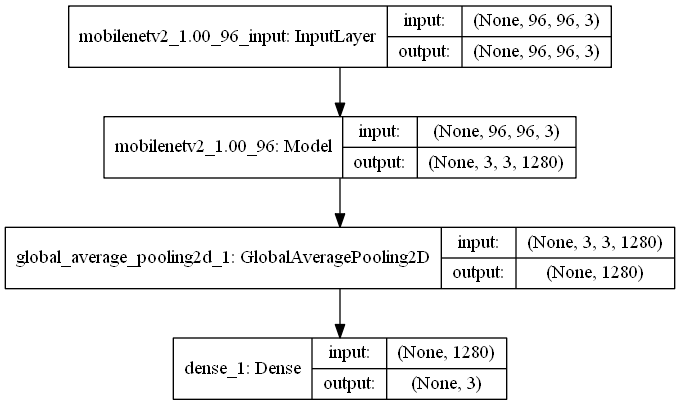

In [8]:
neuralnetwork = Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

neuralnetwork.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['acc'])

neuralnetwork.summary()

plot_model(neuralnetwork, to_file="age_mobilenet.png", show_shapes=True)

In [9]:
history = neuralnetwork.fit_generator(
    training_set,
    validation_data = validation_set,
    callbacks=[es, ckpt, rlp, rlp_val], epochs = 1000, 
    class_weight={0:1, 1:4.5092, 2:1.6111}
)

Epoch 1/1000
591/591 [==============================] - 1163s 2s/step - loss: 1.4930 - acc: 0.5327 - val_loss: 0.8378 - val_acc: 0.5563

Epoch 00001: loss improved from inf to 1.49304, saving model to age_mobilenet.h5
Epoch 2/1000
591/591 [==============================] - 1081s 2s/step - loss: 1.2887 - acc: 0.6140 - val_loss: 1.0986 - val_acc: 0.2565

Epoch 00002: loss improved from 1.49304 to 1.28866, saving model to age_mobilenet.h5
Epoch 3/1000
591/591 [==============================] - 1109s 2s/step - loss: 1.1772 - acc: 0.6468 - val_loss: 1.0986 - val_acc: 0.2968

Epoch 00003: loss improved from 1.28866 to 1.17715, saving model to age_mobilenet.h5
Epoch 4/1000
591/591 [==============================] - 1481s 3s/step - loss: 1.1026 - acc: 0.6894 - val_loss: 1.0986 - val_acc: 0.3400

Epoch 00004: loss improved from 1.17715 to 1.10261, saving model to age_mobilenet.h5
Epoch 5/1000
591/591 [==============================] - 1389s 2s/step - loss: 1.0549 - acc: 0.7041 - val_loss: 0.816

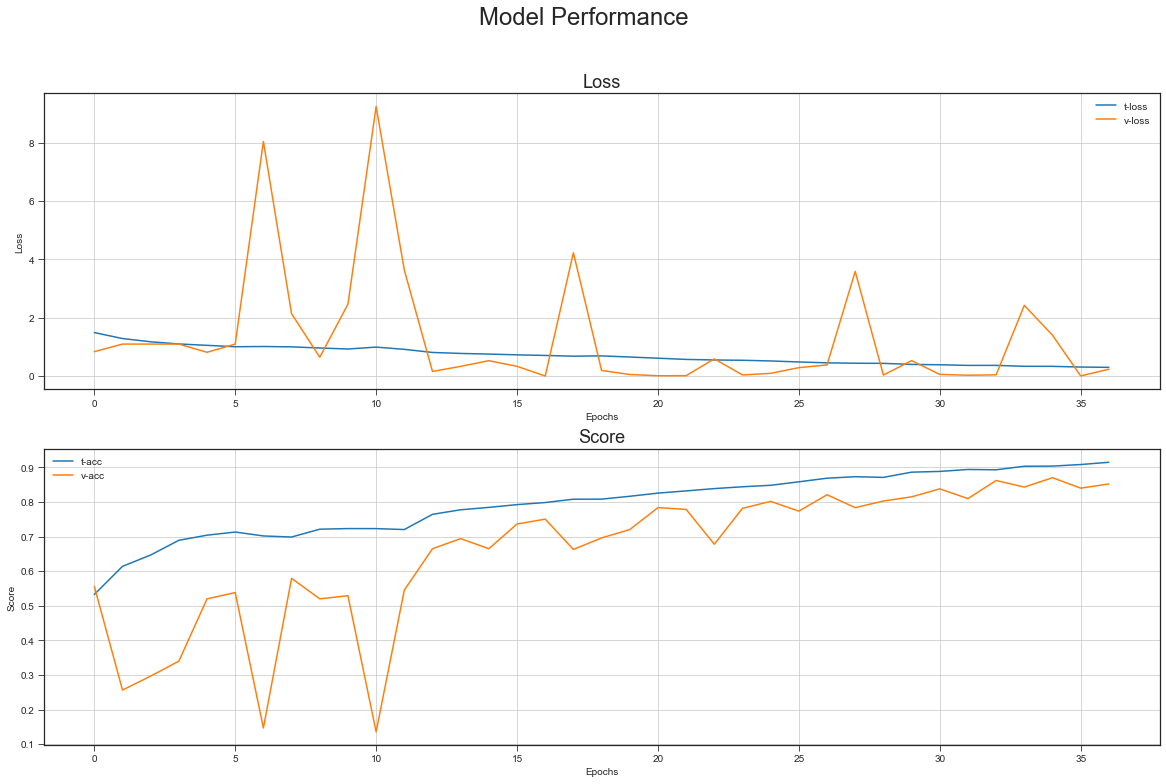

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['acc'], label='t-acc')
ax[1].plot(history.history['val_acc'], label='v-acc')
ax[1].set_title('Score', fontsize=18)
ax[1].set_ylabel('Score')

for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')